Importing Libraries

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils import to_categorical

Loading Data

In [3]:
data = pd.read_csv('Train_Data.csv')
data.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,attack
0,0,tcp,netbios_dgm,REJ,0,0,0,0,0,0,...,0.06,0.06,0.00,0.00,0.00,0.0,1.00,1.0,21,neptune
1,0,tcp,smtp,SF,1239,400,0,0,0,0,...,0.45,0.04,0.00,0.00,0.11,0.0,0.02,0.0,18,normal
2,0,tcp,http,SF,222,945,0,0,0,0,...,1.00,0.00,0.02,0.03,0.00,0.0,0.00,0.0,21,normal
3,0,tcp,http,SF,235,1380,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,21,normal
4,0,tcp,uucp_path,REJ,0,0,0,0,0,0,...,0.01,0.08,0.00,0.00,0.00,0.0,1.00,1.0,19,neptune


Visualising Data

In [4]:
data.urgent.value_counts()
data[data.urgent != 0]

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,attack
50490,2514,tcp,telnet,SF,1937,84751,0,0,2,1,...,0.01,0.01,0.0,0.00,0.0,0.0,0.0,0.0,20,normal
51629,85,tcp,telnet,SF,136,383,0,0,1,0,...,1.00,0.00,1.0,0.78,0.0,0.0,0.0,0.0,19,normal


<Axes: xlabel='urgent'>

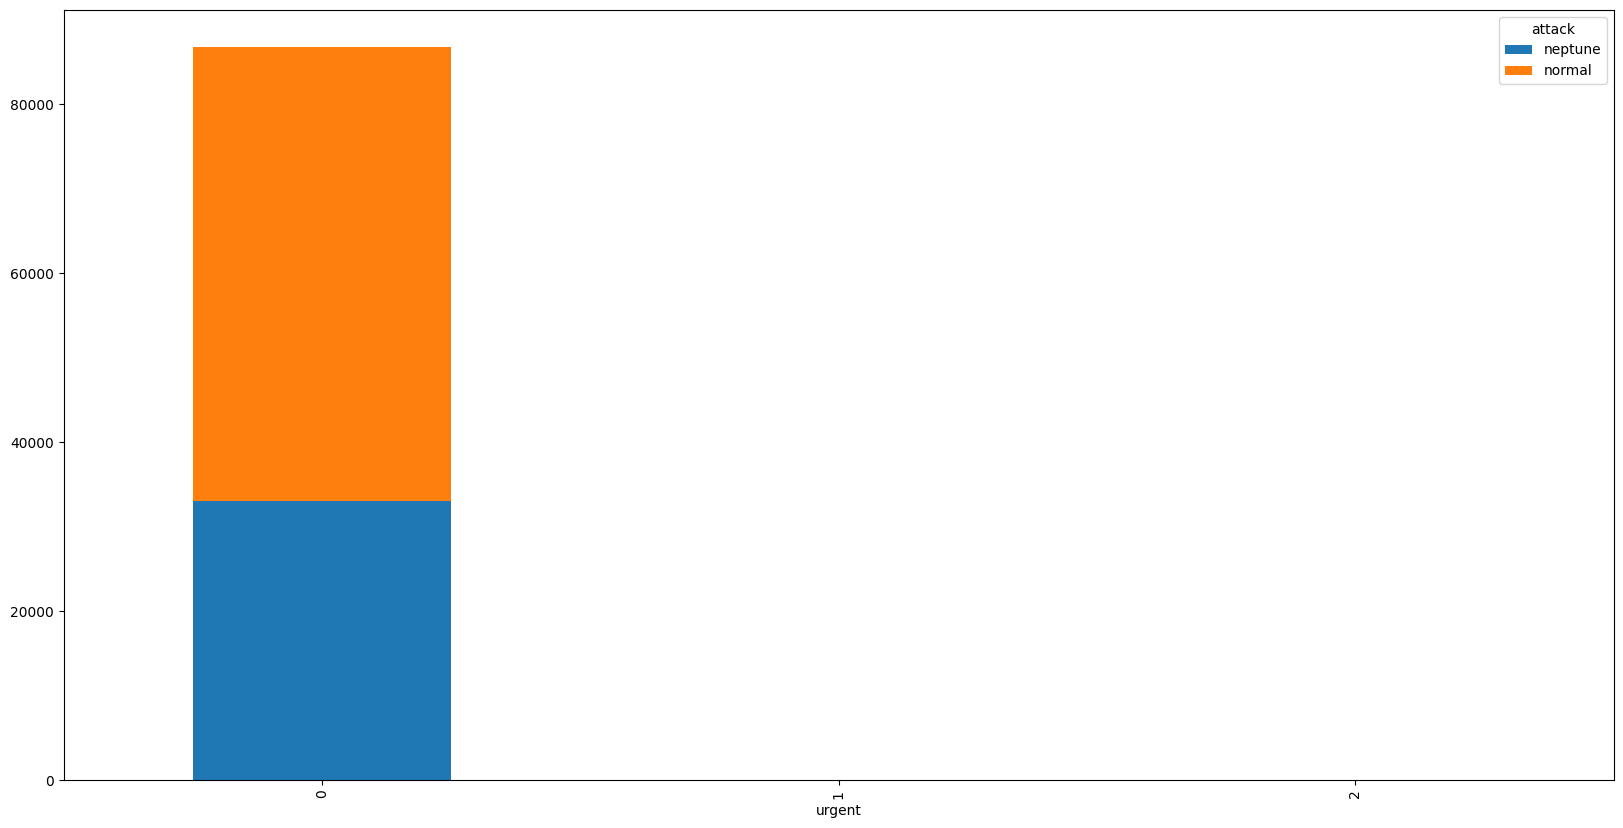

In [5]:
data.groupby(['urgent', 'attack']).size().unstack().plot(kind='bar', stacked=True, figsize=(20, 10))

Removing Uninfluential Parameters

In [6]:
data = data.drop(['wrongfragment', 'numoutboundcmds'], axis=1)

Converting to Numericals

In [7]:
print(data.select_dtypes(exclude=['int', 'float']).columns)

Index(['protocoltype', 'service', 'flag', 'attack'], dtype='object')


In [8]:
data = pd.get_dummies(data, columns=['protocoltype', 'service', 'flag'])
data['attack'] = data['attack'].map({'normal': 0, 'neptune': 1})

data.head()

,duration,srcbytes,dstbytes,land,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,...,flag_OTH,flag_REJ,flag_RSTO,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,0,0,0,0,0,...,False,True,False,False,False,False,False,False,False,False
1,0,1239,400,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,False,True,False
2,0,222,945,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,False,True,False
3,0,235,1380,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,False,True,False
4,0,0,0,0,0,0,0,0,0,0,...,False,True,False,False,False,False,False,False,False,False


Checking for NULL values

In [9]:
data.isnull().sum()

duration    0
srcbytes    0
dstbytes    0
land        0
urgent      0
           ..
flag_S1     0
flag_S2     0
flag_S3     0
flag_SF     0
flag_SH     0
Length: 116, dtype: int64

Splitting and Organising Training Data

In [10]:
y = data.pop('attack')
x = data

print(x.columns)
print(y.value_counts())

Index(['duration', 'srcbytes', 'dstbytes', 'land', 'urgent', 'hot',
       'numfailedlogins', 'loggedin', 'numcompromised', 'rootshell',
       ...
       'flag_OTH', 'flag_REJ', 'flag_RSTO', 'flag_RSTR', 'flag_S0', 'flag_S1',
       'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=115)
attack
0    53847
1    32998
Name: count, dtype: int64


In [11]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = x, x, y, y
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69476, 115), (17369, 115), (69476, 2), (17369, 2))

Building Model

In [12]:
model = Sequential()                                                        # Linear stack of layers
model.add(Input(shape=(115,)))
model.add(Dense(500, activation= "relu"))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 500)            │        58,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,682 (444.07 KB)

 Trainable params: 113,682 (444.07 KB)

 Non-trainable params: 0 (0.00 B)

Training Model

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['f1_score'])
model.fit(X_train, y_train, epochs=17)

Epoch 1/17
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - f1_score: 0.9940 - loss: 0.0211
Epoch 2/17
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - f1_score: 0.9987 - loss: 0.0036
Epoch 3/17
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - f1_score: 0.9989 - loss: 0.0029
Epoch 4/17
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - f1_score: 0.9993 - loss: 0.0019
Epoch 5/17
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - f1_score: 0.9993 - loss: 0.0052
Epoch 6/17
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - f1_score: 0.9994 - loss: 0.0014
Epoch 7/17
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 2s 989us/step - f1_score: 0.9995 - loss: 0.0012
Epoch 8/17
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 2s 999us/step - f1_score: 0.9992 - loss: 0.0029
Epoch 9/17
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - f1_score: 0.9998 - loss: 9.5170e-04
Epoch 10/17
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - f1_score: 0.9997 - loss: 9.2896e-04
Epoch 11/17
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - f1_score: 0.9996 - loss: 8.2777e-04
Epoch 12/17
21

Testing Model

In [14]:
pred_train_probs = model.predict(X_train)
pred_train = np.argmax(pred_train_probs, axis=1)
f1_train = f1_score(np.argmax(y_train, axis=1), pred_train, average='macro')
print('F1 score on training data:', f1_train)

pred_test_probs = model.predict(X_test)
pred_test = np.argmax(pred_test_probs, axis=1)
f1_test = f1_score(np.argmax(y_test, axis=1), pred_test, average='macro')
print('F1 score on test data:', f1_test)

   1/2172 ━━━━━━━━━━━━━━━━━━━━ 1:30 42ms/step

2172/2172 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step
F1 score on training data: 0.9998472571109294
543/543 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
F1 score on test data: 0.9995726075656289


Submission Data

In [15]:
final = pd.read_csv('Test_Data.csv')
final = pd.get_dummies(final, columns=['protocoltype', 'service', 'flag'])
final = final.drop(['wrongfragment', 'numoutboundcmds'], axis=1)
if 'service_tftp_u' not in final.columns:
    final['service_tftp_u'] = False

final.head()

,duration,srcbytes,dstbytes,land,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,...,flag_REJ,flag_RSTO,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,service_tftp_u
0,0,0,0,0,0,0,0,0,0,0,...,True,False,False,False,False,False,False,False,False,False
1,0,199,1721,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,False
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,False,False
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,False,False
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,False,False


In [16]:
final_pred_probs = model.predict(final)
final_pred = pd.Series(np.argmax(final_pred_probs, axis=1))

final_pred.to_csv('check9.csv', index=False, header=['attack'])
final_pred

  1/679 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step

679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step


0        1
1        0
2        1
3        1
4        1
        ..
21707    0
21708    0
21709    1
21710    0
21711    1
Length: 21712, dtype: int64

**Results**

Check1 : 99.98780339065739          [ Initial ]
<br>
Check2 : 99.98780339065739          [ Rerun ]
<br>
Check3 : 99.97560380580629          [ TestSplit 0.2, from 0.3 ]
<br>
Check4 : 99.98780339065739          [ Removing the tftp_u Missing Redundancy ]
<br>
Check5 : 99.98780339065739          [ Removing tftp_u, and TestSplit 0.3 ]
<br>
Check6 : 99.98780339065739          [ Another Neural Layer ]
<br>
Check7 : 99.98780339065739          [ More epochs ]
<br>
Check8 : 99.98780339065739          [ Removing non-unique valued parameters ]

Another Model

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, np.argmax(y_train, axis=1))

pred_train = rf.predict(X_train)
f1_train = f1_score(np.argmax(y_train, axis=1), pred_train, average='macro')
print('F1 score on training data:', f1_train)

F1 score on training data: 1.0


In [18]:
set(final.columns) - set(X_train.columns), set(X_train.columns) - set(final.columns)

(set(), set())

In [19]:
final = final[X_train.columns]
ans = rf.predict(final)

pd.Series(ans).to_csv('check10.csv', index=False, header=['attack'])

In [27]:
selected_rows = x.iloc[[16085, 17542, 19772]]
model.predict(selected_rows)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[1.1243538e-34, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [28]:
rf.predict(selected_rows)

array([1, 0, 0], dtype=int64)